In [4]:
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.table import Table
from astropy.io import fits
import h5py
from Payne.fitting.genmod import GenMod

import os
import csv

In [24]:
def gensynthspec(specNN='', NNtype='', starpars=([]), plot=False):

    # Read in model spectrum parameters
    # model_filename = os.path.expanduser(model_filename)
    # data, header = fits.getdata(model_filename, header=True)

    # define desired parameters
    if starpars:
        print(f"Spectral parameters:\n[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]\n{starpars}")
    else:
        starpars = ([
                1, # Teff
                1, # log(g)
                1, # [Fe/H]
                1, # [a/Fe]
                1, # vrad
                1, # vstar
                1, # vmic
                1, # lsf (R)
                1, # pc0
                1, # pc1
                1, # pc2
                1, # pc3
        ])
        print(f"Spectral parameters:\n[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]\n{starpars}")
    Teff = starpars[0]
    rv = starpars[4]

    # initialize model generation class
    GM = GenMod()
    GM._initspecnn(
        nnpath=specNN,
        NNtype=NNtype)
    
    # generate the model, output is an array of [wave,flux]
    specmod = GM.genspec(starpars, modpoly=True)
    print(specmod)

    # get rid of nans
    # modified from https://stackoverflow.com/a/9537766
    ind = np.where(~np.isnan(specmod[1]))[0]
    first, last = ind[0], ind[-1]
    specmod[1][:first] = specmod[1][first]
    specmod[1][last + 1:] = specmod[1][last]
    
    print('Any nans?')
    if np.any(specmod[1]==np.nan):
        print('Yes')
    else:
        print('No')

    # add noise, setting seed for reproducibility
    np.random.seed(0)

    # mu and sigma come from hectochelle data:
    # file: data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5
    # target id: 2076392838230907392
    mu, sigma = 0.055402016862253524, 0.004453214396949145
    noise = np.random.normal(mu, sigma, len(specmod[0]))
    # print(np.where(noise < 0))
    flux = specmod[1] + noise



    # plot the synthetic spectrum
    fig, ax = plt.subplots()

    if plot:
        # plot the model
        ax.plot(specmod[0]/1E+4, flux, c='C3')
        ax.plot(specmod[0]/1E+4, specmod[1], c='k')

        ax.set_xlabel(r'$\lambda$ ($\mu$m)')
        ax.set_ylabel(r"$F_{\lambda}$")
        ax.set_title('Synthetic Spectrum')
    
        plt.show()
        # plt.savefig(f"synth_spec_T{int(Teff)}.png")

    # output spectrum to csv
    # with open(f'synth_spec_RV{int(rv)}.csv','w') as out:
    #     csv_out=csv.writer(out)
    #     csv_out.writerow(['wave', 'flux', 'eflux'])

    #     for row in zip(specmod[0], flux, noise):
    #         csv_out.writerow(row)
    print(f'synthetic spectrum saved to {os.getcwd()}/synth_spec_RV{int(rv)}.csv')

Spectral parameters:
[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]
[5564.35, 4.16, -0.12, 0.11, 25.86592497, 2.74, 1.0, 32007.42, 1.08, 0.06, 0.0, 0.0]
(array([5102.4401977 , 5102.45720583, 5102.47421402, ..., 5348.42513508,
       5348.44296316, 5348.4607913 ]), array([0.91594106, 0.90785821, 0.90185584, ..., 1.05836996, 1.04527677,
              nan]))
Any nans?
No


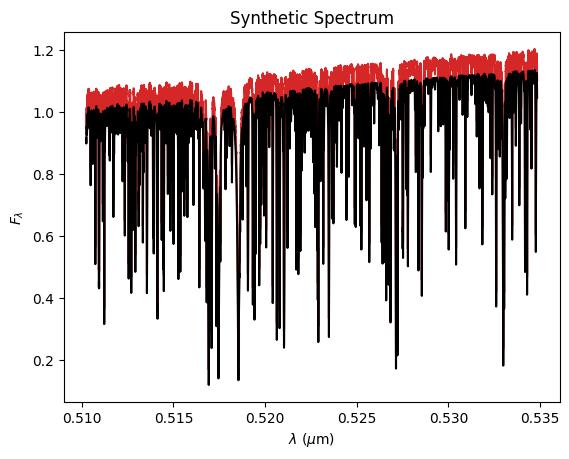

synthetic spectrum saved to /data/labs/douglste-laf-lab/sofairj/uberMSdemo/synth_spec_RV25.csv


In [25]:
specNN='/data/labs/douglaslab/sofairj/demo_binary/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype='LinNet'

starpars = ([
            5564.35, # Teff
            4.16, # log(g)
            -0.12, # [Fe/H]
            0.11, # [a/Fe]
            25.86592497, # vrad
            2.74, # vstar
            1.0, # vmic
            32007.42, # lsf (R)
            1.08, # pc0
            0.06, # pc1
            0.0, # pc2
            0.0, # pc3
    ])

# starpars = ([
#             5300, # Teff
#             3.57, # log(g)
#             -0.12, # [Fe/H]
#             0.11, # [a/Fe]
#             44.17381732, # vrad
#             2.74, # vstar
#             1.0, # vmic
#             32007.42, # lsf (R)
#             1.08, # pc0
#             0.06, # pc1
#             0.0, # pc2
#             0.0, # pc3
#     ])

gensynthspec(specNN=specNN, NNtype=NNtype, starpars=starpars, plot=True)

In [18]:
def gensynthphot(photNN='', NNtype='', starpars=([]), filtarr='', plot=False):
    if starpars:
        print(f"Photometric parameters:\n[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]\n{starpars}")
    else:
        starpars = ([
                1, # Teff
                1, # log(g)
                1, # [Fe/H]
                1, # [a/Fe]
                1, # log(R)
                1, # Dist
                1, # Av
                3.1 # Rv (3.1)
        ])
        print(f"Photometric parameters:\n[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]\n{starpars}")
    Teff = starpars[0]
    logg = starpars[1]

    # initialize model generation class
    GM = GenMod()
    GM._initphotnn(
        filterarray=filtarr,
        nnpath=photNN
    )

    # generate the model, output is an array of [filt_name,mag]
    photmod = GM.genphot(starpars)

    # grab just mags
    photmod = [photmod[xx] for xx in filtarr]

    from uberMS.utils import photsys

    # all filters the NN is trained on + some information on them
    WAVE_d = photsys.photsys()
    # print(f"\nWAVE_d: {WAVE_d}")

    # names of all of the filters the NN is trained on
    photbands_i = WAVE_d.keys()
    # print(f"\nphotbands_i: {photbands_i}")
    
    # names of the filters used in the "observation" (i.e., filters in filtarr)
    photbands = [x for x in photbands_i if x in filtarr]
    print(f"\nphotbands: {photbands}")

    # dict of {filter: wavelength}
    WAVE = {pb:WAVE_d[pb][0] for pb in photbands}
    print(f'\nwave:\n{WAVE}')

    # make some errors (taken from the known SB2 Gaia DR3 2076392838230907392)
    emags = [0.05000091916311386,
             0.05004763662644478,
             0.050012894094444295,
             0.07733692547677395,
             0.08683893326204858,
             0.10121264701645077,
             0.020829461749839007,
             0.02065512096136038,
             0.020870045165005097,
             0.020915354323712318
            ]
             
    # plot the synthetic photometry
    fig, ax = plt.subplots()

    if plot:
        # plot the model
        for wavelength, mag, err in zip(WAVE.values(), photmod, emags):
            ax.scatter(wavelength/1E+4, mag, c='k', s=5)
            ax.errorbar(wavelength/1E+4, mag, yerr=err, ls='',marker=',',c='C3',zorder=1)
    
        ax.set_xlabel(r'$\lambda$ ($\mu$m)')
        ax.set_ylabel(r"Mag.")
        ax.set_title('Synthetic Photometry')
    
        plt.show()
        # plt.savefig(f"synth_spec_T{int(Teff)}.png")

    # output spectrum to csv
    with open(f'synth_phot_g{logg}.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['band','mag','emag'])

        for row in zip(WAVE.keys(), photmod, emags):
            csv_out.writerow(row)
            print(row)
    print(f'synthetic photometry saved to {os.getcwd()}/synth_phot_g{logg}.csv')

Photometric parameters:
[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]
[5564.35, 3.57, -0.12, 0.11, 3.47, 57.134, 1.0, 3.1]

photbands: ['GaiaDR3_G', 'GaiaDR3_BP', 'GaiaDR3_RP', '2MASS_J', '2MASS_H', '2MASS_Ks', 'PS_g', 'PS_r', 'PS_i', 'PS_z']

wave:
{'GaiaDR3_G': 6217.59, 'GaiaDR3_BP': 5109.71, 'GaiaDR3_RP': 7769.02, '2MASS_J': 12350.0, '2MASS_H': 16620.0, '2MASS_Ks': 21590.0, 'PS_g': 4775.6, 'PS_r': 6129.5, 'PS_i': 7484.6, 'PS_z': 8657.8}


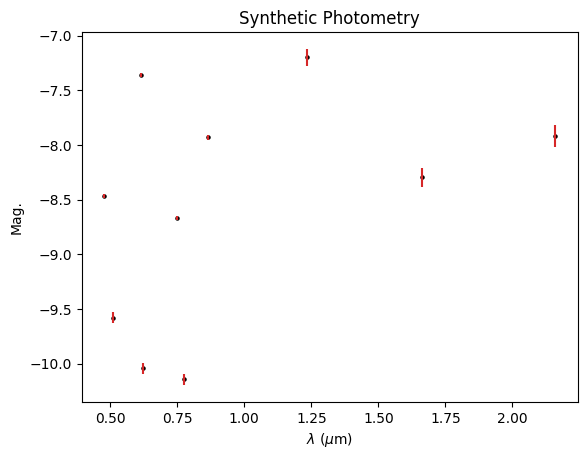

('GaiaDR3_G', -10.04302083875672, 0.05000091916311386)
('GaiaDR3_BP', -9.58014006768941, 0.05004763662644478)
('GaiaDR3_RP', -10.143335055396763, 0.050012894094444295)
('2MASS_J', -7.1985080225608, 0.07733692547677395)
('2MASS_H', -8.294617671194915, 0.08683893326204858)
('2MASS_Ks', -7.921027937373541, 0.10121264701645077)
('PS_g', -8.465367317471964, 0.020829461749839007)
('PS_r', -7.360945117429496, 0.02065512096136038)
('PS_i', -8.666313202274349, 0.020870045165005097)
('PS_z', -7.930015298263717, 0.020915354323712318)
synthetic photometry saved to /data/labs/douglste-laf-lab/sofairj/uberMSdemo/synth_phot_g3.57.csv


In [20]:
photNN='/data/labs/douglaslab/sofairj/demo_binary/models/photNN/'
NNtype='LinNet'
starpars = ([
            5564.35, # Teff
            3.57, # log(g)
            -0.12, # [Fe/H]
            0.11, # [a/Fe]
            3.47, # log(R)
            57.134, # dist (pc)
            1.0, # Av
            3.1, # lsf (R)
    ])

# starpars = ([
#             5300, # Teff
#             4.16, # log(g)
#             -0.12, # [Fe/H]
#             0.11, # [a/Fe]
#             3.47, # log(R)
#             57.134, # dist (pc)
#             1.0, # Av
#             3.1, # lsf (R)
#     ])

filtarr = ['2MASS_H', '2MASS_J', '2MASS_Ks', 'PS_g', 'PS_i', 'PS_r', 'PS_z', 'GaiaDR3_BP', 'GaiaDR3_RP', 'GaiaDR3_G']

gensynthphot(photNN=photNN, NNtype=NNtype, starpars=starpars, filtarr=filtarr, plot=True)

In [65]:
phot = Table.read('/data/labs/douglaslab/sofairj/demo_smes/data/phot.dat',format='ascii')
phot

band,mag,emag
str10,float64,float64
2MASS_H,12.717,0.022
2MASS_J,12.986,0.021
2MASS_Ks,12.636,0.021
GaiaDR3_BP,14.296,0.001
GaiaDR3_G,13.996,0.0002
GaiaDR3_RP,13.531,0.001
PS_g,14.316,0.003
WISE_W1,12.629,0.002
WISE_W2,12.667,0.002


In [112]:
hecto_dir = os.path.expanduser("/data/labs/douglaslab/sofairj/data/hectochelle_rereduction")
hecto_filename = os.path.join(hecto_dir, "data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5")
f = h5py.File(hecto_filename, 'r')


# 2080061393129929088 is the first star listed in the spectrum used here
# 2128158910811247488 is an SB2 whose components are separated in most spectra
# (data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5)
# 2076392838230907392 is another relevant SB2 in NGC 6819
target = str(2076392838230907392)
spec = Table([f[target]['wave'], f[target]['flux'],
              f[target]['eflux']],
              names=('wave', 'flux', 'eflux'))

mu, sigma = np.mean(spec['eflux']), np.std(spec['eflux']) # mean and standard deviation
# np.random.seed(0)
print(mu, sigma)
s = np.random.normal(mu, sigma, 1000)
np.where(s < 0)

0.055402016862253524 0.004453214396949145


(array([], dtype=int64),)

In [65]:
Table.read('synth_phot_g4.16.csv')

band,mag,emag
str10,float64,float64
GaiaDR3_G,-16.637890924089547,0.0002
GaiaDR3_BP,-16.175446561166957,0.001
GaiaDR3_RP,-16.7349998115222,0.001
2MASS_J,-13.789127976469755,0.021
2MASS_H,-14.885809065278274,0.022
2MASS_Ks,-14.520227531090923,0.021
PS_g,-15.064029344687393,0.003
PS_r,-13.96255753187274,0.002
PS_i,-15.256110508864127,0.002


In [66]:
Table.read('synth_spec_RV25.csv')

wave,flux
float64,float64
5102.440197695679,0.9791987780213753
5102.457205829671,0.9650422135158241
5102.474214020357,0.9616163899832707
5102.491222267738,0.9638556680558885
5102.508230571812,0.9619547877060304
5102.5252389325815,0.9524901320304844
5102.542247350043,0.967582529367561
5102.5592558242015,0.971924688223348
5102.576264355054,0.9825635202153464


In [67]:
Table.read('/data/labs/douglaslab/sofairj/demo_smes/data/spec.fits')

wave,flux,eflux
float64,float64,float64
5161.64046596433,0.9021604351753327,0.01586838420787538
5161.6763744446935,0.8904994204128546,0.015663848162090852
5161.712282964459,0.8583511156871554,0.015541735412101455
5161.748191522999,0.9012593649353366,0.016247957815424034
5161.784100119691,0.8842099674743273,0.016010860259184998
5161.820008753912,0.8977161753036198,0.015765932387728682
5161.855917425038,0.8761846855011014,0.015823697982853702
5161.891826132445,0.9386886460872208,0.01621463381504781
5161.927734875512,0.9274239849355111,0.015726902866162944
